In [1]:
import casadi as ca
import numpy as np

def integrator(f: ca.Function, x: ca.SX, u: ca.SX, dt: ca.SX):
    k1 = f(x, u)
    k2 = f(x + 0.5 * dt * k1, u)
    k3 = f(x + 0.5 * dt * k2, u)
    k4 = f(x + dt * k3, u)
    return x + (dt/ 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)


# symbolic dynamics model for estimation and control
q_BI = ca.SX.sym('q_BI', 4)
omega = ca.SX.sym('omega', 3)
omega_w = ca.SX.sym("omega_w", 3)
x = ca.vertcat(q_BI, omega, omega_w)
u = ca.SX.sym('inputs', 6)
u_rw = u[:3]
u_mag = u[3:]

J_hat = np.eye(3,3)
J_w = np.ones(1)
A_hat = np.eye(3,3)
dt = 0.01

                    
qx, qy, qz, qw = q_BI[0], q_BI[1], q_BI[2], q_BI[3]
wx, wy, wz = omega[0], omega[1], omega[2]
q_dot = 0.5 * ca.vertcat(
    -qx*wx - qy*wy - qz*wz,
    qw*wx + qy*wz - qz*wy,
    qw*wy - qx*wz + qz*wx,
    qw*wz + qx*wy - qy*wx
)

h_int = A_hat @ (J_w * (omega_w + A_hat @ omega)) 
tau_rw = A_hat @ u_rw # electrical dynamics not included
tau_mag = u_mag # TODO: implement

cross_term = ca.cross(omega, J_hat @ omega + h_int)
total_torque = tau_mag - tau_rw - cross_term
omega_dot = ca.solve(J_hat, total_torque)
omega_w_dot = u_rw / J_w - A_hat @ omega_dot

dx = ca.vertcat(q_dot, omega_dot, omega_w_dot)

f = ca.Function("system_dynamics", [x, u], [dx])

x_next = integrator(f, x, u, dt)

F = ca.Function("F", [x, u, dt], [x_next], ['x','u','dt'], ['x_next'])

RuntimeError: Error in Function::Function for 'F' [SXFunction] at .../casadi/core/function.cpp:241:
.../casadi/core/function_internal.cpp:152: Error calling SXFunction::init for 'F':
.../casadi/core/x_function.hpp:335: For F: Xfunction input arguments must be purely symbolic.
Argument 2(dt) is not symbolic.

In [ ]:
ca.SX.zeros(3)

AttributeError: module 'casadi' has no attribute 'zeros'

In [ ]:
from filterpy.kalman import ExtendedKalmanFilter
import casadi as ca

# TODO: implement extended kalman filter wrapper
class IMUEKF(ExtendedKalmanFilter):
    def __init__(self, dim_x, dim_z, f: ca.Function, g: ca.Function):
        super().__init__(dim_x, dim_z)

        self.f = f # process model

        dt = ca.SX.sym("dt")
        self.F = integrator(self.f, self.x, u, dt) # function returns next state
        
        self.g = g # measurement model

        self.g_jac = g.jacobian()

    def predict_x(self, u, dt):
        self.x = self.F(self.x, u, dt)

    def update(self, z):

        super().update(z, self.g_jac, self.g)


In [ ]:
import json

eos_path = r"tudsat-trace_eos.json"


with open(eos_path, "r") as f:
    eos_file = json.load(f)

eos_file["ModelObjects"]["Reaction Wheel1"]["Orientation"]

In [3]:
from actuators import ReactionWheel, Magnetorquer
from kinematics import euler_ocr_to_sbc
from satellite import Spacecraft, Surface, replace_orientation_matrices, string_to_matrix
import json
import datetime
from sensors import *
from simulation import Simulation
from scipy.spatial.transform import Rotation as R

eos_path = r"tudsat-trace_eos.json"


with open(eos_path, "r") as f:
    eos_file = json.load(f)

data = replace_orientation_matrices(eos_file)  

trace = data["ModelObjects"]["TRACE"]

m = trace["StructureMass"]
J_B = string_to_matrix(trace["StructureMomentOfInertia"])

# # TODO: in satellite factory classmethod
surfaces = [Surface.from_eos_panel(v) for k, v in data["ModelObjects"].items() if "panel" in k.lower()]
rws = [ReactionWheel(0.2e-3, 6000, 2e-6, a) for a in [[1, 0, 0], [0, 1, 0], [0, 0, 1]]]
magnetorquers = [Magnetorquer(0.2e-2, a) for a in [[1, 0, 0], [0, 1, 0], [0, 0, 1]]]

dt = 0.01
sun_sensor = SunSensor(dt, 0.0)
magnetometer = Magnetometer(dt, 0.0, [0, 0, 0])
gps = GPS(dt, 0.0)
accelerometer = Accelerometer(dt, 0.0, 0.0)
gyro = Gyroscope(dt, 0.0, 0.0)
rw_speed_sensors = RW_tachometer(dt, 0.0)

Spacecraft(m, J_B, surfaces, rws, magnetorquers, sun_sensor, magnetometer, gps, accelerometer, gyro, rw_speed_sensors)


In [4]:
import datetime

datetime.datetime(datetime.MINYEAR, 1, 1)

datetime.datetime(1, 1, 1, 0, 0)

In [ ]:
def simplify_eos(eos_file_path: str, out_path: str):
    with open(eos_file_path, "r") as f:
        eos_file = json.load(f)

    data = replace_orientation_matrices(eos_file)  

    

In [ ]:
from itertools import cycle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.colors import TABLEAU_COLORS


## code for plotting surfaces
surfaces: list[Surface]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


# solar panel = 10x10cm 
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

names = [k for k, v in data["ModelObjects"].items() if "panel" in k.lower()] 
for i, s in enumerate(surfaces):
    c = next(colors)
    s.plot(ax, c, 0.05, 0.05)
    ax.scatter(*s.pos, c=c, label=names[i])
#surfaces[1].plot(ax)
ax.set_ylabel("Y axis")
ax.set_xlabel("X axis")
ax.set_zlabel("Z axis")
print(s.center)
print(s.normal)
print(s.area)
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# ax.set_zlim(-2, 2)
ax.set_aspect("equal")
ax.legend()
fig.tight_layout()

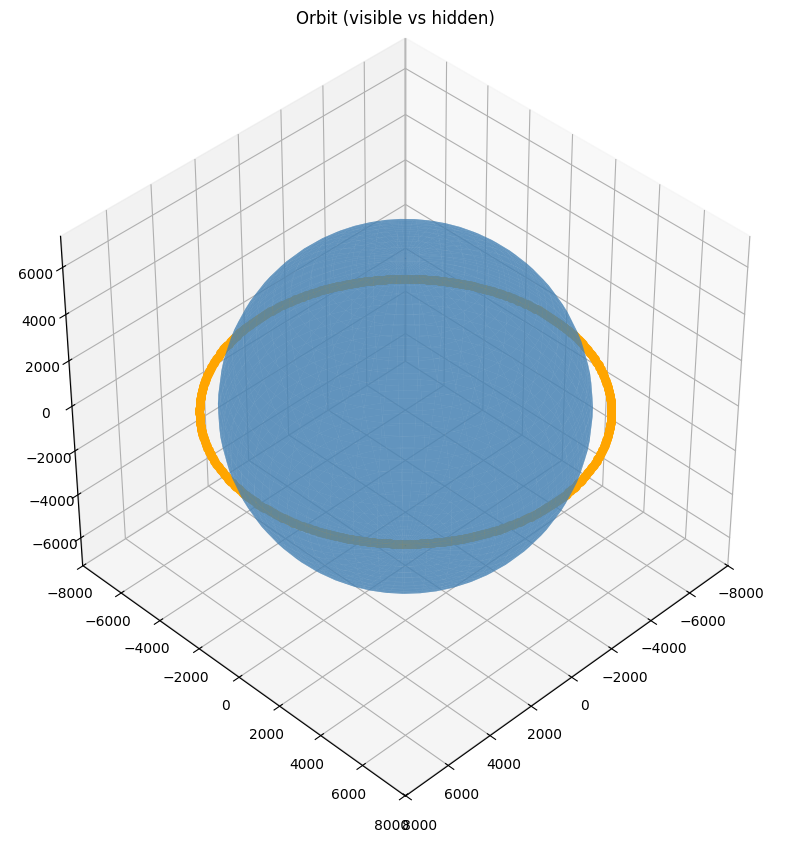

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def compute_camera_vector(elev, azim):
    """Convert matplotlib elev/azim to a camera direction vector."""
    az = np.deg2rad(azim)
    el = np.deg2rad(elev)

    # camera points from origin outward
    cx = np.cos(el) * np.cos(az)
    cy = np.cos(el) * np.sin(az)
    cz = np.sin(el)
    return np.array([cx, cy, cz])

def points_in_front(points, R_earth, cam_vec):
    """
    Returns a boolean array: True if point is in front of the Earth,
    False if hidden behind sphere.
    """
    # Vector from Earth center (0,0,0) to point
    P = points

    # Check if point is behind the sphere when projected along cam_vec
    # Condition: camera sees P if dot(P, cam_vec) > sqrt(R^2 - d^2)
    # Equivalent: the perpendicular distance to line-of-sight must exceed sphere radius.

    # Projection of P onto camera vector
    proj = P @ cam_vec

    # Perpendicular distance from sphere center to line going to P
    perp = np.linalg.norm(P - np.outer(proj, cam_vec), axis=1)

    # Visible if:
    # 1) perpendicular distance > radius (not intersecting sphere)
    # 2) proj > 0 (in front of camera)
    visible = (perp >= R_earth) | (proj > 0)
    return visible

# -------------------------
# Example orbit
# -------------------------
R_orbit = 7000
theta = np.linspace(0, 2*np.pi, 600)
x = R_orbit * np.cos(theta)
y = R_orbit * np.sin(theta)
z = np.zeros_like(theta)#1000 * np.sin(theta * 2)  # some 3D shape
points = np.column_stack([x, y, z])

R_earth = 6371  # km

# -------------------------
# Plot
# -------------------------
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Camera angles
elev = 40
azim = 45
ax.view_init(elev=elev, azim=azim)

cam_vec = compute_camera_vector(elev, azim)
visible_mask = points_in_front(points, R_earth, cam_vec)

# -------------------------
# Plot Earth sphere
# -------------------------
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
xs = R_earth * np.cos(u) * np.sin(v)
ys = R_earth * np.sin(u) * np.sin(v)
zs = R_earth * np.cos(v)

ax.plot_surface(xs, ys, zs, color='steelblue', shade=False, alpha=0.6, zorder=0)

# -------------------------
# Plot visible + hidden orbit segments
# -------------------------
# Visible part
for x_, y_, z_, vis in zip(x, y, z, visible_mask):
    ax.scatter(x_, y_, z_,
        color='orange', linewidth=2, alpha=1, zorder=10)

# # Hidden part (optional)
# ax.plot(x[~visible_mask], y[~visible_mask], z[~visible_mask],
#         color='gray', linestyle='dashed', linewidth=1)

ax.set_aspect("equal")
plt.title("Orbit (visible vs hidden)")
plt.show()



In [5]:
from disturbances import R_EARTH, MU
from kinematics import quaternion_kinematics, quaternion_product
from simulation import rk4_step
import datetime
import numpy as np

q_c = np.array([0, 0, 0, 1])

w_0 = np.sqrt(MU / R_EARTH) / (R_EARTH + 800)
w_c = np.array([0, w_0, 0, 0])

t = datetime.datetime.now()

dt = 1
T = np.arange(0, 60*60*10, dt) / 60
Q_c = []
for i in range(T.size):
    q_c = rk4_step(lambda x, u, t: 0.5 * quaternion_kinematics(x, u), q_c, w_c[:3], t, datetime.timedelta(seconds=dt))
    Q_c.append(q_c)
    # Q_dot_c = [0.5 * quaternion_product(w_c, q_c) for i in range(T.size)]

# plt.plot(T, Q_dot_c)

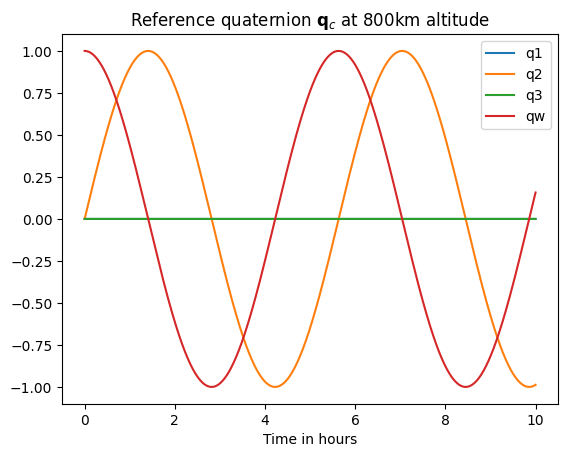

In [8]:
import matplotlib.pyplot as plt

plt.plot(T/60, np.array(Q_c)[:, :], label=["q1", "q2", "q3", "qw"])
plt.title(r"Reference quaternion $\mathbf{q}_c$ at $800$km altitude")
plt.xlabel("Time in hours")
plt.legend()
plt.show()